# Embedding Bengalese finch song syllables in latent space with UMAP and VocalPy

This is a demo of embedding the syllables of Bengalese finch song in a two-dimensional space with the dimensionality reduction algorithm [UMAP (Uniform Manifold Approximation & Projection)](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html).

For a more general guide please see:  
https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/1365-2656.13754
and the accompanying GitHub repository https://github.com/marathomas/tutorial_repo,
as well as the original paper and repository from Sainburg et al. 2020:
* https://github.com/timsainb/avgn_paper/tree/V2
* https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008228

Import VocalPy

In [1]:
import pandas as pd

import vocalpy as voc

Load data (that we downloaded in notebook 0).

In [2]:
data_dir = ('data/bfsongrepo/gy6or6/032312/')

wav_paths = voc.paths.from_dir(data_dir, 'wav')
csv_paths = voc.paths.from_dir(data_dir, '.wav.csv')  # annotations

In [3]:
import crowsetta

In [4]:
audios = [voc.Audio.read(wav_path) for wav_path in wav_paths]
annots = [voc.Annotation.read(csv_path, format='simple-seq') for csv_path in csv_paths]

## Data preparation

In this notebook we want to embed the syllables of Bengalese finch song with UMAP.  
First we prepare the dataset.

The first step requires us to have segmented the audio into constituent [units of analysis](https://onlinelibrary.wiley.com/doi/abs/10.1111/brv.12160?casa_token=OzzQcd7O9AQAAAAA:jkcnLBuWBlia0tHFmffTMziy9cXtAVwVraJm43mw7GQgDqGsmpZ-9omjv4X6FABVnd7KMcZST1Gl8mA), in this case the syllables of Bengalese finch song. It is also helpful to have annotated the existing annotations with some number of classes, especially for the purpose of inspecting the results of the UMAP embedding.

There are of course many methods to segment and annotate animal sounds, that are beyond the scope of this tutorial (we might be slightly biased but we recommend you try [TweetyNet](https://github.com/yardencsGitHub/tweetynet), that is now built into the [vak](https://github.com/vocalpy/vak) library.

We use a helper function to load each audio file and then use the corresponding annotation to get the audio for each annotated segment--a birdsong syllable--as well as the label.

In [5]:
import numpy as np


def get_segment_audio(audios, annots, labelset=list('iabcdefghjk'), min_length=1024):
    """Get audio for every segment in every sequence.
    Pad audio for each segment so they are all the same size.
    Here we use the naive approach of just padding all segments 
    with neighoring audio so they are the same size as the largest.
    Note this might not be a good idea for the general case,
    if there are very brief silent gaps
    (or no silent gaps) between segments.
    
    Parameters
    ----------
    audios : list
        of vocalpy.Audio
    annots: list
        of vocalpy.Annotation, annotated sequences in ``audios``
        
    Returns
    -------
    audios_out : list
        vocalpy.Audio instances that contain just the segment clips
    labels_out : list
        The label given to each segment in the annotations
    """
    audios_out = []
    labels_out = []
    for annot, audio in zip(annots, audios):

        # ---- convert sequence of units to array of starts and stop times
        start_times = annot.data.seq.onsets_s
        stop_times = annot.data.seq.offsets_s

        start_inds = np.round(start_times * audio.samplerate).astype(int)
        stop_inds = np.round(stop_times * audio.samplerate).astype(int)
        
        labels = annot.data.seq.labels

        for start, stop, label in zip(start_inds, stop_inds, labels):
            if label not in labelset:
                continue
            segment_audio = audio.data[start:stop]
            if segment_audio.shape[-1] < min_length:
                continue
            audios_out.append(
                voc.Audio(data=segment_audio, samplerate=audio.samplerate)
            )
            labels_out.append(label)
    return audios_out, labels_out

In [6]:
segment_audios, segment_labels = get_segment_audio(audios, annots)

In [7]:
from collections import defaultdict

label_audio_map = defaultdict(list)

MAX_NUM_AUDIOS = 700

for audio, label in zip(segment_audios, segment_labels):
    if len(label_audio_map[label]) < MAX_NUM_AUDIOS:
        label_audio_map[label].append(audio)

# we throw away the old lists and make new ones that we use below
segment_labels, segment_audios = [], []
for label in label_audio_map.keys():
    segment_audios.extend(label_audio_map[label])
    segment_labels.extend([label] * len(label_audio_map[label]))
del label_audio_map

In [8]:
spect_params = {'fft_size': 512, 'step_size': 64, 'transform_type': 'log_spect'}
callback = voc.signal.spectrogram.spectrogram
spect_maker = voc.SpectrogramMaker(callback=callback, spect_params=spect_params)
segment_spects = spect_maker.make(segment_audios, parallelize=True)

[########################################] | 100% Completed | 291.75 ms


As in Sainburg et al. 2020 and Thomas et al. 2022, we pad all spectrograms so they are the same "width" (number of columns) as the maximum.

In [9]:
widths = [
    segment_spect.data.shape[-1]
    for segment_spect in segment_spects
]
pad_length = max(widths)

We also min-max scale the spectrogram so the values lie between 0 and 1, again as in Sainburg et al. 2020 and Thomas et al. 2022. This avoids a situation where e.g. a spectrogram in decibels has negative values, and we pad with 0 which is larger than the negative value.

In [10]:
def minmax_scale(spectrogram):
    """Min-max scales the spectrogram data to be between 0 and 1"""
    data = spectrogram.data
    min_ = data.min()
    max_ = data.max()
    return (data - min_) / (max_ - min_)


def pad_spectrogram(data, pad_length):
    """ Pads spectrogram array to being a certain width 
    (columns, assumed to be time bins)"""
    excess_needed = pad_length - np.shape(data)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        data, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

In [11]:
# this is a nested list comprehension, not the easiest thing to read
X = np.array(
    [pad_spectrogram(
        # we minmax scale *first*, then pad the returned array
        minmax_scale(segment_spect), pad_length
    ) for segment_spect in segment_spects]
)

In [12]:
X.shape

(7700, 257, 82)

We visualize the data after the transformations, to inspect what's going in to the model.

In [13]:
import matplotlib.pyplot as plt

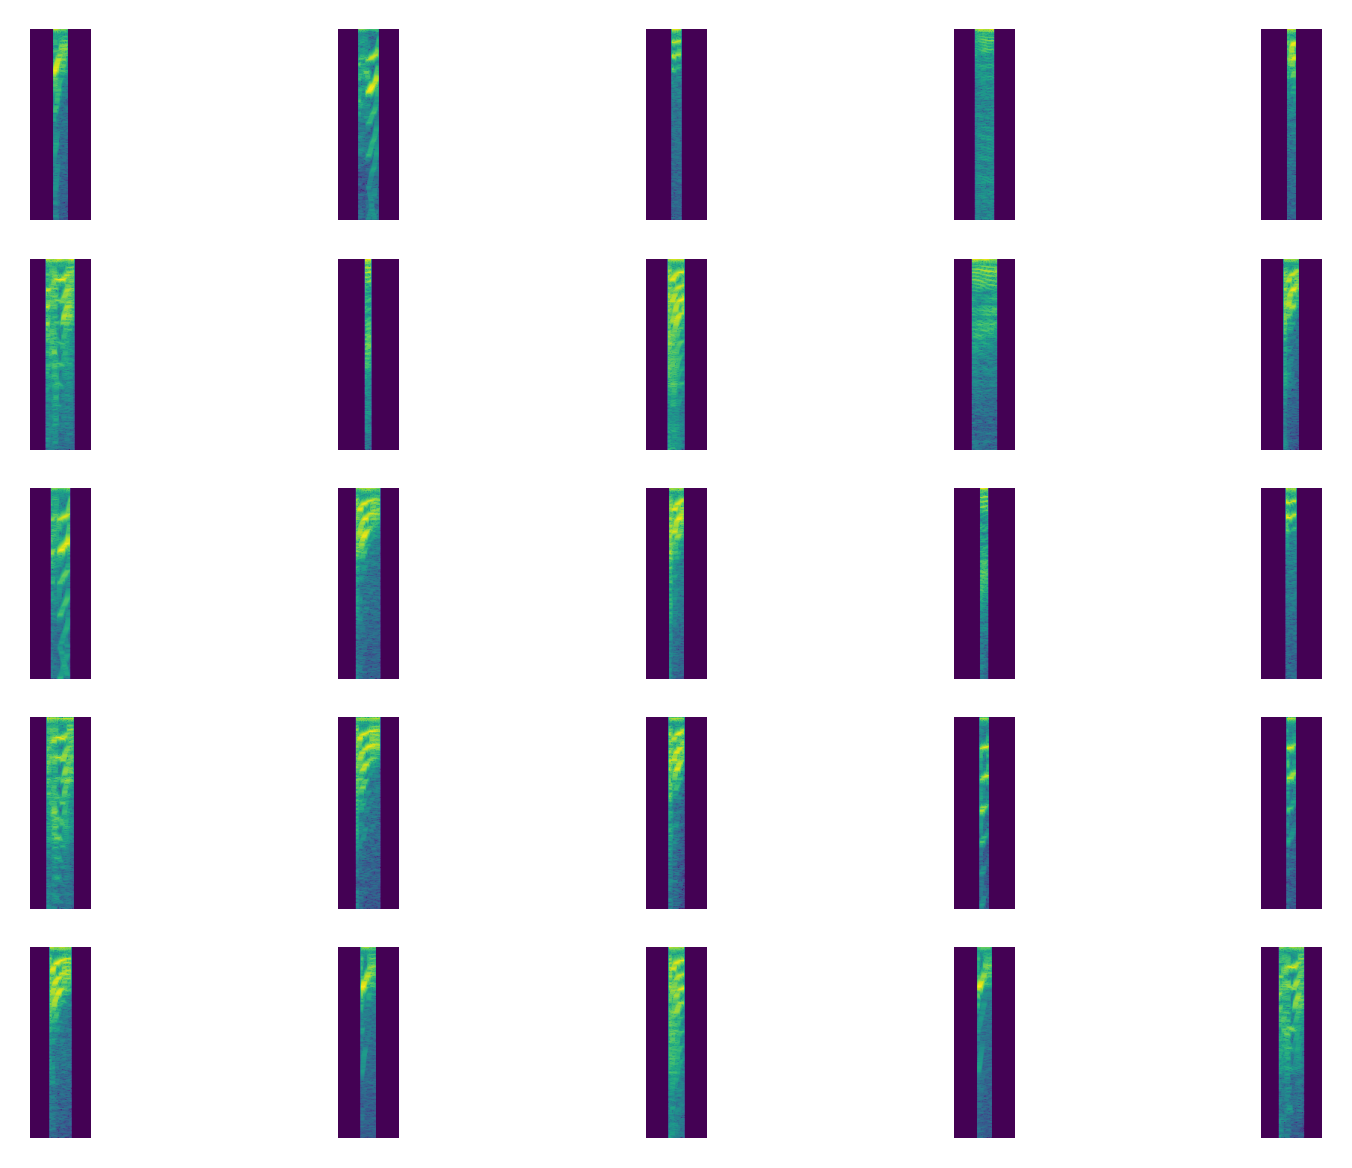

In [14]:
fig, ax_arr = plt.subplots(5, 5, dpi=300)
ax_arr = ax_arr.ravel()

inds = np.random.permutation(np.arange(X.shape[0]))[:25]

to_viz = X[inds]

for x, ax in zip(to_viz, ax_arr):
    ax.imshow(x)
    ax.set_axis_off()

In [15]:
X = X.reshape(X.shape[0], -1)

In [16]:
X.shape

(7700, 21074)

## Embed with UMAP

In [17]:
import umap

/home/pimienta/miniconda3/envs/vocalpy-notebooks-env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pimienta/miniconda3/envs/vocalpy-notebooks-env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pimienta/miniconda3/envs/voc

In [18]:
umapper = umap.UMAP(min_dist=1.0)

In [19]:
out = umapper.fit_transform(X)

We confirm that we have embedded the syllables in a two-dimensonal space

In [20]:
out.shape

(7700, 2)

## Visualize the embeddings
adapted from https://github.com/timsainb/avgn_paper/blob/V2/avgn/visualization/projections.py

We make a color palette for the labels

In [21]:
import seaborn as sns

sns.set('notebook')
pal = sns.color_palette("tab20", n_colors=len(np.unique(segment_labels)))
label_color_map = {lab: pal[i] for i, lab in enumerate(np.unique(segment_labels))}

In [22]:
segment_labels = np.array(segment_labels)

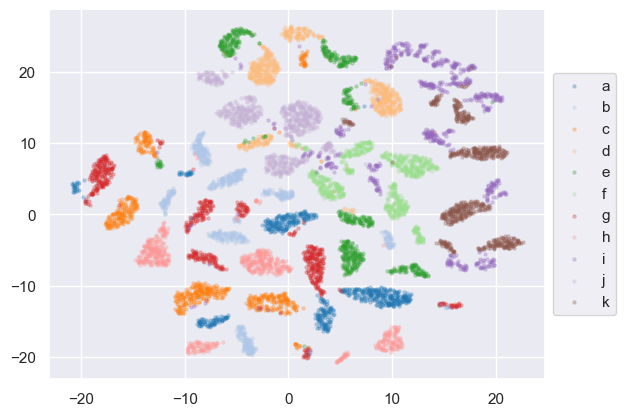

In [23]:
fig, ax = plt.subplots()
for label in np.unique(segment_labels):
    inds = segment_labels == label
    ax.scatter(
        out[inds, 0],
        out[inds, 1],
        alpha=0.25,
        s=5,
        color=label_color_map[label],
        label=label,
    )

ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])

This is a simple demo where we have not fine tuned the data preparation or the embedding step. An alternative approach is to replace one step of UMAP with a neural network model as described in [Sainburg et al. 2021](https://direct.mit.edu/neco/article/33/11/2881/107068), known as Parametric UMAP (because the neural network "parametrizes" the transform that embeds the high-dimensional segments).

We have not yet carefully benchmarked various approaches but our initial tests with Parametric UMAP, as implemented in the vak library, suggest that it can yield more consistent clusters for this specific dataset. See results here: https://conference.scipy.org/proceedings/scipy2023/pdfs/david_nicholson.pdf